In [1]:
# --- 0. Import Libraries ---
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import time # Untuk mengukur waktu

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb # Perlu install: pip install xgboost
import lightgbm as lgb # Perlu install: pip install lightgbm

# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
# Mengabaikan peringatan
warnings.filterwarnings("ignore")



In [2]:
# --- 1. Memuat Data ---
try:
    df = pd.read_csv("cardetails.csv")
    print("Dataset 'cardetails.csv' berhasil dimuat.")
    print(f"Dimensi awal dataset: {df.shape}")
except FileNotFoundError:
    print("Error: File 'cardetails.csv' tidak ditemukan. Pastikan file berada di direktori yang benar.")
    exit()

# --- 2. Pra-pemrosesan Data ---

# Menghapus kolom tidak relevan
df_processed = df.drop(columns=["name", "torque"], axis=1)
print("\nKolom 'name' dan 'torque' dihapus.")

# Menangani data duplikat
initial_rows = df_processed.shape[0]
df_processed.drop_duplicates(inplace=True)
rows_after_duplicates = df_processed.shape[0]
print(f"\nMemeriksa data duplikat...")
if initial_rows > rows_after_duplicates:
    print(f"{initial_rows - rows_after_duplicates} baris duplikat dihapus.")
else:
    print("Tidak ada data duplikat.")
print(f"Dimensi data setelah hapus duplikat: {df_processed.shape}")


Dataset 'cardetails.csv' berhasil dimuat.
Dimensi awal dataset: (8128, 13)

Kolom 'name' dan 'torque' dihapus.

Memeriksa data duplikat...
1221 baris duplikat dihapus.
Dimensi data setelah hapus duplikat: (6907, 11)


In [3]:

# Membersihkan kolom numerik dari teks (kmpl, CC, bhp)
def clean_numeric_col(series):
    return pd.to_numeric(series.str.extract('(\d+\.?\d*)', expand=False), errors='coerce')

df_processed['mileage'] = clean_numeric_col(df_processed['mileage'])
df_processed['engine'] = clean_numeric_col(df_processed['engine'])
df_processed['max_power'] = clean_numeric_col(df_processed['max_power'])
df_processed['seats'] = pd.to_numeric(df_processed['seats'], errors='coerce')
print("\nKolom 'mileage', 'engine', 'max_power', 'seats' dibersihkan.")

# Memisahkan Fitur (X) dan Target (y)
y = df_processed['selling_price']
X = df_processed.drop('selling_price', axis=1)
print(f"\nTarget (y) adalah 'selling_price'. Jumlah fitur (X) awal: {X.shape[1]}")

# Membagi Data (Training & Testing) SEBELUM preprocessing lanjut
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData dibagi: {X_train.shape[0]} training, {X_test.shape[0]} testing.")

# Mendefinisikan tipe kolom (pada X_train)
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
print(f"Kolom Numerik: {numerical_cols}")
print(f"Kolom Kategorikal: {categorical_cols}")



Kolom 'mileage', 'engine', 'max_power', 'seats' dibersihkan.

Target (y) adalah 'selling_price'. Jumlah fitur (X) awal: 10

Data dibagi: 5525 training, 1382 testing.
Kolom Numerik: ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats']
Kolom Kategorikal: ['fuel', 'seller_type', 'transmission', 'owner']



Imputasi nilai null selesai.


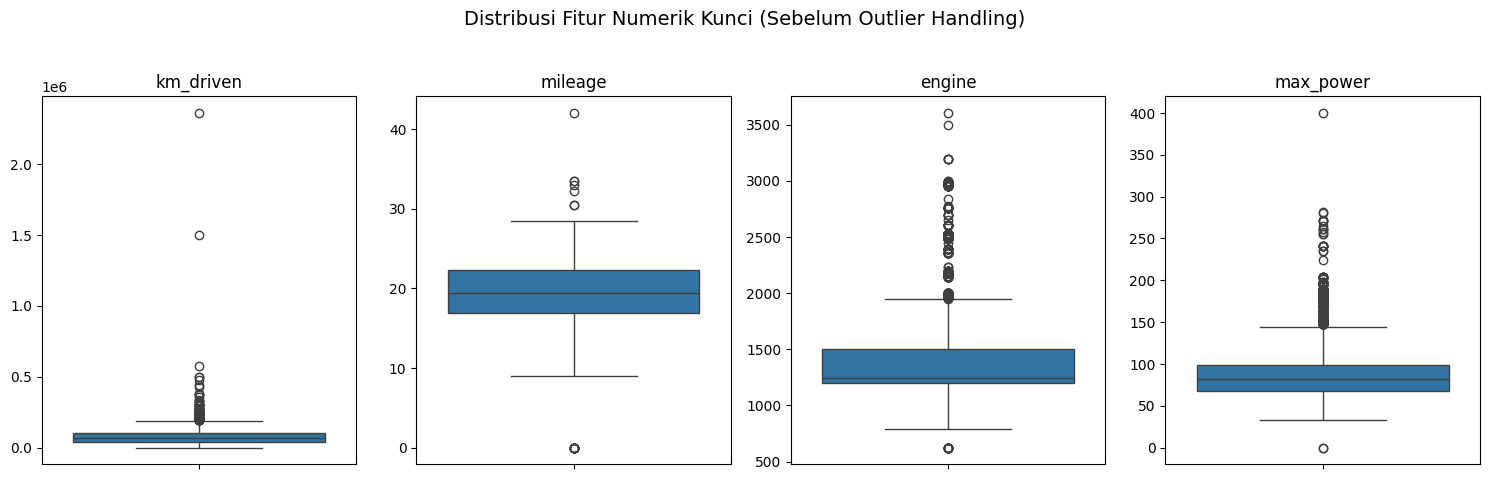

In [4]:

# --- Imputasi Nilai Hilang (secara manual sebelum outlier handling) ---
# Dilakukan pada copy agar data asli X_train tetap ada untuk visualisasi
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

imputer_num = SimpleImputer(strategy='mean')
X_train_imputed[numerical_cols] = imputer_num.fit_transform(X_train[numerical_cols])
X_test_imputed[numerical_cols] = imputer_num.transform(X_test[numerical_cols])

imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_imputed[categorical_cols] = imputer_cat.fit_transform(X_train[categorical_cols])
X_test_imputed[categorical_cols] = imputer_cat.transform(X_test[categorical_cols])
print("\nImputasi nilai null selesai.")

# --- Visualisasi Outlier (Sebelum Handling) ---
# Kolom yang relevan untuk outlier check
cols_for_outlier_check = ['km_driven', 'mileage', 'engine', 'max_power']
plt.figure(figsize=(15, 5))
plt.suptitle("Distribusi Fitur Numerik Kunci (Sebelum Outlier Handling)", fontsize=14)
for i, col in enumerate(cols_for_outlier_check):
    if col in X_train_imputed.columns:
        plt.subplot(1, len(cols_for_outlier_check), i + 1)
        sns.boxplot(y=X_train_imputed[col]) # Gunakan data yg sudah diimputasi
        plt.title(col)
        plt.ylabel('')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [5]:

# --- Penanganan Outlier (IQR Capping, manual setelah imputasi) ---
print("\nMenangani outlier pada data training (IQR Capping)...")
X_train_outlier_handled = X_train_imputed.copy()
lower_bounds = {}
upper_bounds = {}

for col in cols_for_outlier_check:
    if col in X_train_outlier_handled.columns:
        Q1 = X_train_outlier_handled[col].quantile(0.25)
        Q3 = X_train_outlier_handled[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        lower_bounds[col] = lower_bound
        upper_bounds[col] = upper_bound
        # Terapkan capping pada data training
        X_train_outlier_handled[col] = np.clip(X_train_outlier_handled[col], lower_bound, upper_bound)

# Terapkan capping ke test set (menggunakan batas dari training set)
print("Menerapkan capping outlier ke data test...")
X_test_outlier_handled = X_test_imputed.copy()
for col in cols_for_outlier_check:
     if col in X_test_outlier_handled.columns:
        lower_bound = lower_bounds.get(col)
        upper_bound = upper_bounds.get(col)
        if lower_bound is not None and upper_bound is not None:
            X_test_outlier_handled[col] = np.clip(X_test_outlier_handled[col], lower_bound, upper_bound)

# --- Pipeline Preprocessing Akhir (Scaling & Encoding) ---
# Pipeline untuk fitur numerik: Scaling (imputasi sudah dilakukan)
numeric_transformer_final = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline untuk fitur kategorikal: Encoding (imputasi sudah dilakukan)
categorical_transformer_final = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Gabungkan transformer
preprocessor = ColumnTransformer(
    transformers=[
        # Gunakan nama kolom numerik dan kategorikal yang sudah didefinisikan
        ('num', numeric_transformer_final, numerical_cols),
        ('cat', categorical_transformer_final, categorical_cols)
    ],
    remainder='passthrough' # Jaga-jaga jika ada kolom tak terduga
)

# Fit preprocessor pada data training (yg sudah diimputasi & outlier handled)
# Transform data training dan testing
print("\nMenerapkan Scaling (numerik) dan OneHotEncoding (kategorikal)...")
X_train_prepared = preprocessor.fit_transform(X_train_outlier_handled)
X_test_prepared = preprocessor.transform(X_test_outlier_handled)

# Mendapatkan nama fitur setelah transformasi (untuk interpretasi)
try:
    num_feature_names = numerical_cols
    cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    all_feature_names = list(num_feature_names) + list(cat_feature_names)
    print(f"Jumlah fitur setelah preprocessing: {len(all_feature_names)}")
except AttributeError:
    all_feature_names = None
    print("Warning: Tidak dapat mengambil nama fitur secara otomatis.")



Menangani outlier pada data training (IQR Capping)...
Menerapkan capping outlier ke data test...

Menerapkan Scaling (numerik) dan OneHotEncoding (kategorikal)...
Jumlah fitur setelah preprocessing: 16


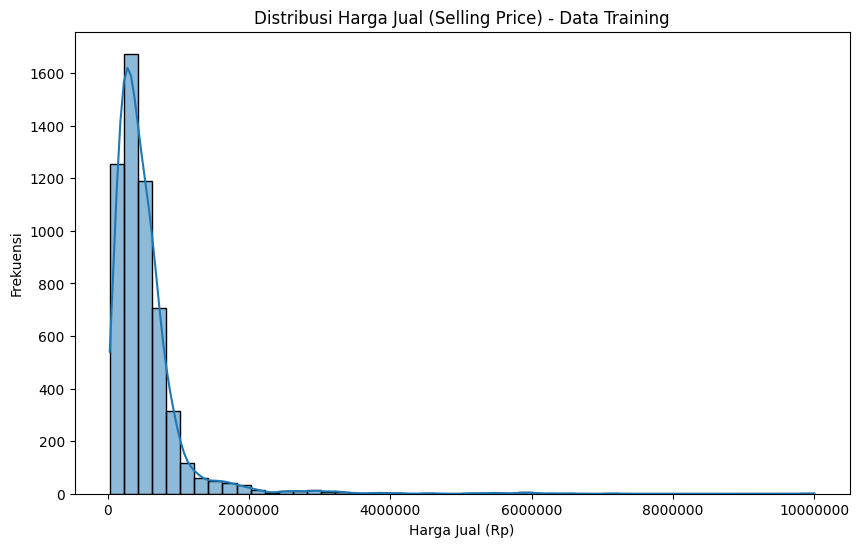

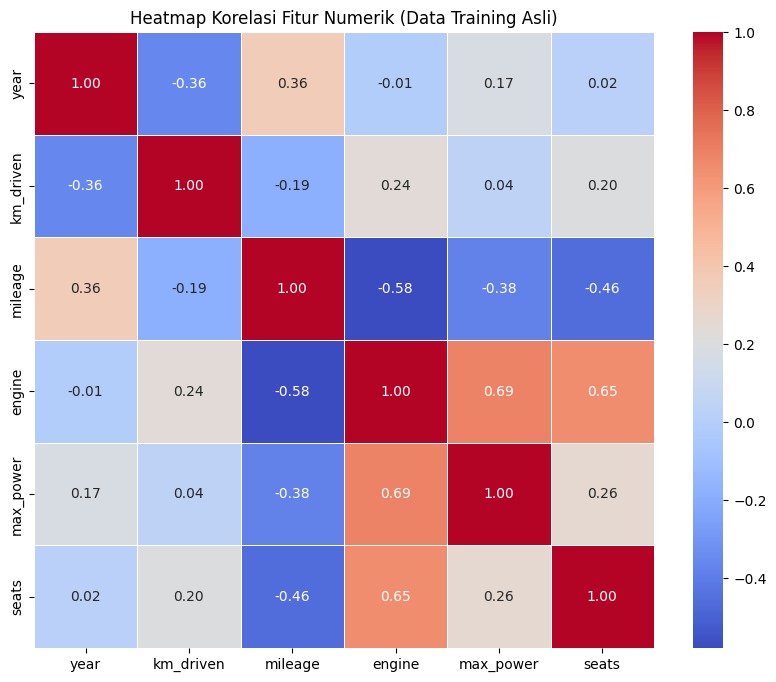

In [6]:

# --- 3. Visualisasi EDA Tambahan (Opsional) ---
# Distribusi Target (Harga Jual)
plt.figure(figsize=(10, 6))
sns.histplot(y_train, kde=True, bins=50)
plt.title('Distribusi Harga Jual (Selling Price) - Data Training')
plt.xlabel('Harga Jual (Rp)')
plt.ylabel('Frekuensi')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

# Korelasi Fitur Numerik (pada data training sebelum outlier handling/scaling)
plt.figure(figsize=(10, 8))
# Pilih kolom numerik asli dari X_train
numeric_cols_original = X_train.select_dtypes(include=np.number).columns
correlation_matrix = X_train[numeric_cols_original].corr() # Hitung korelasi
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap Korelasi Fitur Numerik (Data Training Asli)')
plt.show()



Memulai Pemodelan & Evaluasi Awal (Cross-Validation)...
Evaluasi CV untuk: Linear Regression...
  R² (mean +/- std): 0.5637 +/- 0.0621
  RMSE (mean +/- std): 349213.94 +/- 63172.73
  Waktu CV: 3.55 detik

Evaluasi CV untuk: Decision Tree...
  R² (mean +/- std): 0.7161 +/- 0.0741
  RMSE (mean +/- std): 278671.24 +/- 54473.30
  Waktu CV: 1.24 detik

Evaluasi CV untuk: Random Forest...
  R² (mean +/- std): 0.8322 +/- 0.0491
  RMSE (mean +/- std): 216832.66 +/- 58415.21
  Waktu CV: 4.25 detik

Evaluasi CV untuk: Gradient Boosting...
  R² (mean +/- std): 0.8071 +/- 0.0316
  RMSE (mean +/- std): 232934.69 +/- 48595.36
  Waktu CV: 1.11 detik

Evaluasi CV untuk: XGBoost...
  R² (mean +/- std): 0.8177 +/- 0.0470
  RMSE (mean +/- std): 225158.32 +/- 53288.08
  Waktu CV: 0.42 detik

Evaluasi CV untuk: LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not en

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/skle

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 4420, number of used features: 14
[LightGBM] [Info] Start training from score 517390.267873
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 750
[LightGBM] [Info] Number of data points in the train set: 4420, number of used features: 14
[LightGBM] [Info] Start training from score 521027.672851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/skle

  R² (mean +/- std): 0.8210 +/- 0.0556
  RMSE (mean +/- std): 223481.61 +/- 61512.50
  Waktu CV: 2.11 detik


--- Perbandingan Rata-rata Metrik Evaluasi Model (Cross-Validation) ---
                   R2_CV_Mean   RMSE_CV_Mean
Random Forest        0.832231  216832.662385
LightGBM             0.820991  223481.605173
XGBoost              0.817686  225158.318750
Gradient Boosting    0.807092  232934.685162
Decision Tree        0.716112  278671.240788
Linear Regression    0.563659  349213.937996


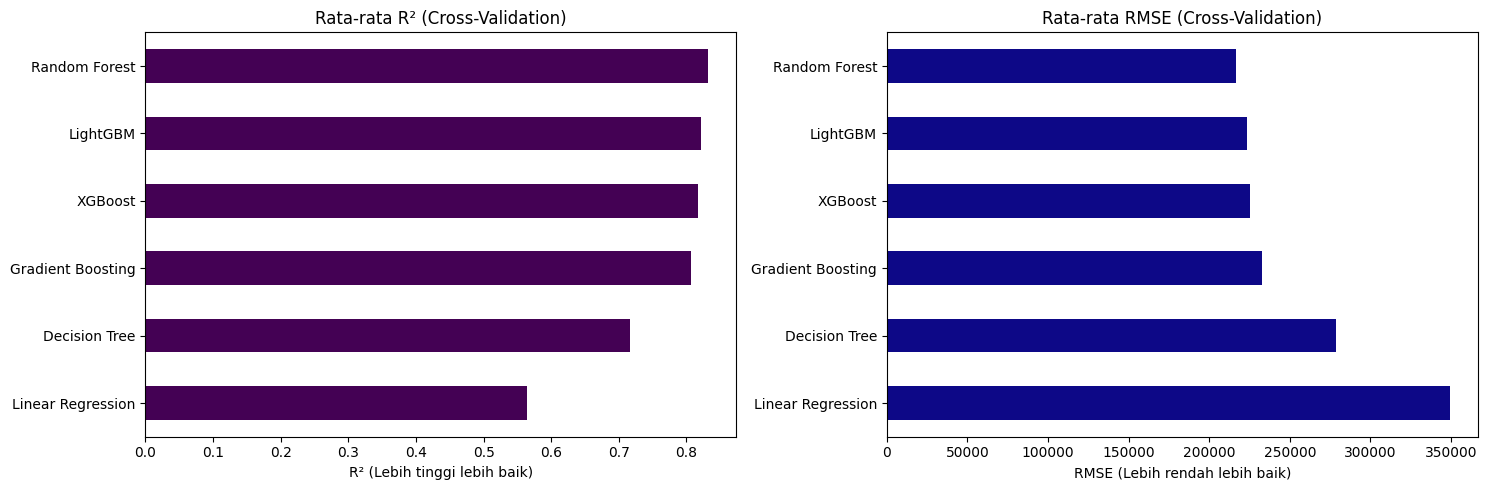

In [7]:

# --- 4. Pemodelan & Evaluasi Awal (Cross-Validation) ---
print("\nMemulai Pemodelan & Evaluasi Awal (Cross-Validation)...")

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, objective='reg:squarederror'),
    "LightGBM": lgb.LGBMRegressor(random_state=42)
}

cv_results_r2 = {}
cv_results_rmse = {}
n_folds = 5

for name, model in models.items():
    print(f"Evaluasi CV untuk: {name}...")
    start_time = time.time()
    # Evaluasi pada data training yang sudah dipreprocess lengkap
    r2_scores = cross_val_score(model, X_train_prepared, y_train, cv=n_folds, scoring='r2', n_jobs=-1)
    rmse_scores = cross_val_score(model, X_train_prepared, y_train, cv=n_folds, scoring='neg_root_mean_squared_error', n_jobs=-1)
    cv_results_r2[name] = r2_scores
    cv_results_rmse[name] = -rmse_scores # Ambil nilai absolut
    end_time = time.time()
    print(f"  R² (mean +/- std): {r2_scores.mean():.4f} +/- {r2_scores.std():.4f}")
    print(f"  RMSE (mean +/- std): {np.mean(-rmse_scores):.2f} +/- {np.std(-rmse_scores):.2f}")
    print(f"  Waktu CV: {end_time - start_time:.2f} detik\n")

# --- A. Perbandingan Hasil Model (dari CV) ---
results_cv = {name: {'R2_CV_Mean': cv_results_r2[name].mean(), 'RMSE_CV_Mean': cv_results_rmse[name].mean()} for name in models}
results_cv_df = pd.DataFrame(results_cv).T
print("\n--- Perbandingan Rata-rata Metrik Evaluasi Model (Cross-Validation) ---")
print(results_cv_df.sort_values(by='R2_CV_Mean', ascending=False))

# Plot Perbandingan CV
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
results_cv_df['R2_CV_Mean'].sort_values().plot(kind='barh', ax=axes[0], colormap='viridis')
axes[0].set_title('Rata-rata R² (Cross-Validation)')
axes[0].set_xlabel('R² (Lebih tinggi lebih baik)')
results_cv_df['RMSE_CV_Mean'].sort_values(ascending=False).plot(kind='barh', ax=axes[1], colormap='plasma')
axes[1].set_title('Rata-rata RMSE (Cross-Validation)')
axes[1].set_xlabel('RMSE (Lebih rendah lebih baik)')
plt.tight_layout()
plt.show()


In [8]:

# --- 5. Hyperparameter Tuning (RandomizedSearchCV) ---
print("\nMemulai Hyperparameter Tuning (RandomizedSearchCV)...")
tuning_results_models = {} # Simpan model terbaik hasil tuning

# Contoh Tuning untuk Random Forest dan XGBoost
models_to_tune = ["Random Forest", "XGBoost"] # Bisa tambahkan model lain
param_dists = {
    "Random Forest": {
        'n_estimators': [int(x) for x in np.linspace(start=100, stop=500, num=5)],
        'max_depth': [10, 20, 30, None], 'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2', 1.0]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300, 400, 500], 'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9], 'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0], 'gamma': [0, 0.1, 0.2]
    }
}

for name in models_to_tune:
    if name in models:
        print(f"\nTuning {name}...")
        estimator = models[name] # Ambil model dasar
        param_dist = param_dists[name]
        random_search = RandomizedSearchCV(estimator=estimator, param_distributions=param_dist,
                                           n_iter=20, cv=3, verbose=0, random_state=42,
                                           n_jobs=-1, scoring='r2')
        start_time = time.time()
        random_search.fit(X_train_prepared, y_train)
        end_time = time.time()
        print(f"  Selesai dalam {end_time - start_time:.2f} detik.")
        print(f"  Parameter terbaik: {random_search.best_params_}")
        print(f"  Skor R2 CV terbaik: {random_search.best_score_:.4f}")
        tuning_results_models[f'{name} Tuned'] = random_search.best_estimator_
    else:
        print(f"Model {name} tidak ditemukan untuk tuning.")




Memulai Hyperparameter Tuning (RandomizedSearchCV)...

Tuning Random Forest...
  Selesai dalam 26.94 detik.
  Parameter terbaik: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
  Skor R2 CV terbaik: 0.8269

Tuning XGBoost...
  Selesai dalam 4.69 detik.
  Parameter terbaik: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
  Skor R2 CV terbaik: 0.8400



Evaluasi Final Model pada Test Set...
Evaluasi: Linear Regression
  MAE : 175564.92
  RMSE: 318010.99
  R2  : 0.5429

Evaluasi: Decision Tree
  MAE : 106314.21
  RMSE: 226596.57
  R2  : 0.7679

Evaluasi: Random Forest
  MAE : 82324.13
  RMSE: 172702.48
  R2  : 0.8652

Evaluasi: Gradient Boosting
  MAE : 99656.99
  RMSE: 190044.61
  R2  : 0.8368

Evaluasi: XGBoost
  MAE : 79340.23
  RMSE: 161545.81
  R2  : 0.8820

Evaluasi: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 5525, number of used features: 14
[LightGBM] [Info] Start training from score 520091.062986
  MAE : 88446.17
  RMSE: 190499.51
  R2  : 0.8360

Evaluasi: Random Forest Tuned
  MAE : 82851.69
  RMSE: 174768.49
  R2  : 0.8619

Evaluasi: XGBoost Tune

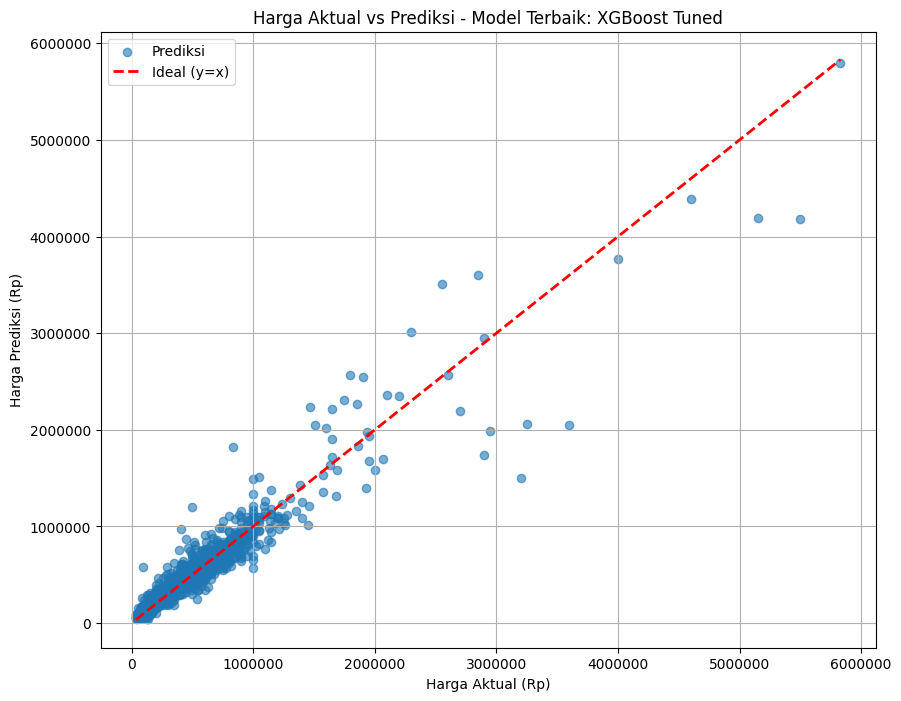


Menampilkan Feature Importance dari model terbaik (XGBoost Tuned)...


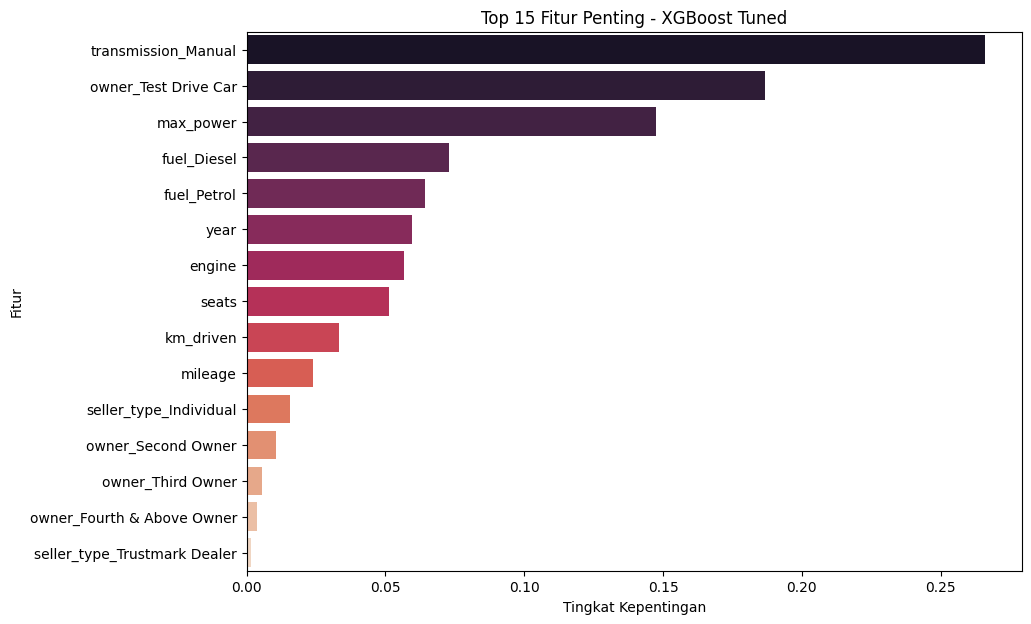

In [9]:

# --- 6. Evaluasi Final pada Test Set ---
print("\nEvaluasi Final Model pada Test Set...")
final_results = {}
# Gabungkan model asli dan model hasil tuning untuk evaluasi final
final_models_to_evaluate = {**models, **tuning_results_models}

for name, model in final_models_to_evaluate.items():
    print(f"Evaluasi: {name}")
    # Latih ulang model asli (model tuning sudah dilatih)
    if name in models:
         model.fit(X_train_prepared, y_train)

    y_pred = model.predict(X_test_prepared)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    final_results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}
    print(f"  MAE : {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2  : {r2:.4f}\n")

final_results_df = pd.DataFrame(final_results).T
print("\n--- Perbandingan Metrik Evaluasi Final (Test Set) ---")
print(final_results_df.sort_values(by='R2', ascending=False))

# Pilih model terbaik final berdasarkan R2 pada test set
best_final_model_name = final_results_df['R2'].idxmax()
best_final_model = final_models_to_evaluate[best_final_model_name]
print(f"\nModel terbaik final (berdasarkan R2 test set): {best_final_model_name}")

# Plot Actual vs Predicted untuk model terbaik final
plt.figure(figsize=(10, 8))
y_pred_best_final = best_final_model.predict(X_test_prepared)
plt.scatter(y_test, y_pred_best_final, alpha=0.6, label='Prediksi')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2, label='Ideal (y=x)')
plt.xlabel("Harga Aktual (Rp)")
plt.ylabel("Harga Prediksi (Rp)")
plt.title(f"Harga Aktual vs Prediksi - Model Terbaik: {best_final_model_name}")
plt.ticklabel_format(style='plain', axis='both')
plt.legend()
plt.grid(True)
plt.show()

# (Opsional) Feature Importance dari model terbaik (jika model mendukung)
if hasattr(best_final_model, 'feature_importances_') and all_feature_names is not None:
    print(f"\nMenampilkan Feature Importance dari model terbaik ({best_final_model_name})...")
    importances = best_final_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(15) # Tampilkan top 15

    plt.figure(figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')
    plt.title(f'Top 15 Fitur Penting - {best_final_model_name}')
    plt.xlabel('Tingkat Kepentingan')
    plt.ylabel('Fitur')
    plt.show()


In [10]:


# --- 7. Prediksi untuk Mobil Hipotetis Tahun 2024 ---
print("\nMembuat Prediksi untuk Mobil Hipotetis Tahun 2024...")

# Definisikan fitur mobil hipotetis (berdasarkan rata-rata/modus X_train asli)
hypothetical_car_dict = {
    'year': 2024, 'km_driven': X_train['km_driven'].mean(),
    'fuel': X_train['fuel'].mode()[0], 'seller_type': X_train['seller_type'].mode()[0],
    'transmission': X_train['transmission'].mode()[0], 'owner': X_train['owner'].mode()[0],
    'mileage': X_train['mileage'].mean(), 'engine': X_train['engine'].mean(),
    'max_power': X_train['max_power'].mean(), 'seats': round(X_train['seats'].median())
}
hypothetical_car = pd.DataFrame([hypothetical_car_dict])
print("\nFitur Mobil Hipotetis (Sebelum Preprocessing):")
print(hypothetical_car)
# Pastikan urutan kolom sesuai dengan saat preprocessor di-fit
hypothetical_car = hypothetical_car[X_train.columns]

# Terapkan preprocessor yang sudah di-fit
try:
    hypothetical_car_prepared = preprocessor.transform(hypothetical_car)
    print("\nPreprocessing mobil hipotetis berhasil.")
    # Ambil model Linear Regression dan model terbaik final yang sudah dilatih
    model_lr = final_models_to_evaluate["Linear Regression"]
    # best_final_model sudah dipilih sebelumnya

    # Lakukan prediksi
    pred_lr_hypothetical = model_lr.predict(hypothetical_car_prepared)
    pred_best_hypothetical = best_final_model.predict(hypothetical_car_prepared)

    print(f"\nPrediksi Harga Jual untuk mobil rata-rata hipotetis tahun 2024:")
    print(f"  - Menggunakan Linear Regression        : Rp {pred_lr_hypothetical[0]:,.2f}")
    print(f"  - Menggunakan Model Terbaik ({best_final_model_name}): Rp {pred_best_hypothetical[0]:,.2f}")

except Exception as e:
    print(f"\nError saat memproses atau memprediksi mobil hipotetis: {e}")
    pred_lr_hypothetical = [np.nan] # Set default jika error
    pred_best_hypothetical = [np.nan]



Membuat Prediksi untuk Mobil Hipotetis Tahun 2024...

Fitur Mobil Hipotetis (Sebelum Preprocessing):
   year     km_driven    fuel seller_type transmission        owner  \
0  2024  74617.465158  Diesel  Individual       Manual  First Owner   

     mileage     engine  max_power  seats  
0  19.440343  1431.0625  87.860255      5  

Preprocessing mobil hipotetis berhasil.

Prediksi Harga Jual untuk mobil rata-rata hipotetis tahun 2024:
  - Menggunakan Linear Regression        : Rp 949,195.92
  - Menggunakan Model Terbaik (XGBoost Tuned): Rp 463,073.81


In [11]:

# --- 8. Kesimpulan & Analisis Akhir ---
print("\n--- Kesimpulan & Analisis Akhir ---")
print("* Proyek ini berhasil membangun model regresi untuk memprediksi harga jual mobil bekas.")
print("* Pra-pemrosesan data (pembersihan, imputasi, outlier handling, encoding, scaling) adalah langkah krusial.")
print("* Cross-validation menunjukkan model berbasis pohon (RF, GB, XGB, LGBM) lebih unggul dari Linear Regression.")
print("* Hyperparameter tuning (RandomizedSearchCV) membantu optimasi model RF dan XGBoost.")

# Mengambil hasil model terbaik dari evaluasi final
best_r2_final = final_results_df.loc[best_final_model_name, 'R2']
best_rmse_final = final_results_df.loc[best_final_model_name, 'RMSE']
print(f"* Model terbaik final pada test set adalah '{best_final_model_name}' dengan R² = {best_r2_final:.4f} dan RMSE = {best_rmse_final:.2f}.")

# Analisis
print("\n* Analisis:")
print("  Harga mobil bekas dipengaruhi oleh banyak faktor. Model machine learning dapat menangkap sebagian besar hubungan ini,")
print("  namun akurasi prediksi dibatasi oleh kualitas dan kelengkapan data yang tersedia.")
print("  Fitur seperti tahun ('year'), jarak tempuh ('km_driven'), tenaga ('max_power'), dan kapasitas mesin ('engine')")
print("  kemungkinan besar merupakan prediktor utama harga jual (seperti yang mungkin terlihat dari plot feature importance).")

# Prediksi Hipotetis
print(f"\n* Prediksi harga untuk mobil hipotetis tahun 2024 (fitur lain = rata-rata/modus training):")
if not np.isnan(pred_lr_hypothetical[0]):
    print(f"    - Linear Regression        : Rp {pred_lr_hypothetical[0]:,.2f}")
    print(f"    - Model Terbaik ({best_final_model_name}): Rp {pred_best_hypothetical[0]:,.2f}")
    print("  Perbedaan prediksi menyoroti kemampuan model terbaik (non-linear) dalam menangkap pola kompleks dibandingkan model linear.")
else:
    print("    - Prediksi mobil hipotetis tidak dapat ditampilkan karena error sebelumnya.")

# Rekomendasi
print("\n* Rekomendasi:")
print(f"  Gunakan model terbaik ('{best_final_model_name}') untuk prediksi harga mobil bekas di masa depan.")
print("  Lakukan monitoring performa model secara berkala terhadap data baru dan latih ulang (retrain) model secara periodik")
print("  atau jika terjadi penurunan performa yang signifikan.")
print("  Pertimbangkan eksplorasi feature engineering lebih lanjut (misalnya, membuat fitur interaksi, fitur polynomial,")
print("  atau menggunakan metode encoding kategorikal yang berbeda) untuk potensi peningkatan akurasi.")
print("  Pertimbangkan pengumpulan data tambahan (misalnya, informasi kondisi detail, riwayat servis, lokasi geografis)")
print("  jika memungkinkan, karena ini dapat secara signifikan mempengaruhi harga jual dan meningkatkan performa model.")

print("\n--- Analisis Regresi Lanjutan Selesai ---")


--- Kesimpulan & Analisis Akhir ---
* Proyek ini berhasil membangun model regresi untuk memprediksi harga jual mobil bekas.
* Pra-pemrosesan data (pembersihan, imputasi, outlier handling, encoding, scaling) adalah langkah krusial.
* Cross-validation menunjukkan model berbasis pohon (RF, GB, XGB, LGBM) lebih unggul dari Linear Regression.
* Hyperparameter tuning (RandomizedSearchCV) membantu optimasi model RF dan XGBoost.
* Model terbaik final pada test set adalah 'XGBoost Tuned' dengan R² = 0.9005 dan RMSE = 148402.86.

* Analisis:
  Harga mobil bekas dipengaruhi oleh banyak faktor. Model machine learning dapat menangkap sebagian besar hubungan ini,
  namun akurasi prediksi dibatasi oleh kualitas dan kelengkapan data yang tersedia.
  Fitur seperti tahun ('year'), jarak tempuh ('km_driven'), tenaga ('max_power'), dan kapasitas mesin ('engine')
  kemungkinan besar merupakan prediktor utama harga jual (seperti yang mungkin terlihat dari plot feature importance).

* Prediksi harga untuk m